- ouputs 2 attributes
- filters to 1 country

In [1]:
import pandas as pd
from sklearn.base import TransformerMixin
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split

import tensorflow_probability as tfp
import tensorflow as tf

from utils.metrics import smape, mase, mis, coverage

# check keras version
print(tf.keras.__version__)
print(tf.__version__)

print(tf.__version__)
print(tfp.__version__)
print(tf.config.list_physical_devices('GPU')) # available GPUs


2.5.0
2.5.0
2.5.0
0.13.0
[]


In [2]:
data_path = 'data/owid-covid-data.csv'
#url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv' # get latest data

#df = pd.read_csv(url)
#print(df.to_string())
#df.to_csv(data_path)

In [3]:
df = pd.read_csv(data_path)

In [4]:
print(df.location.unique())
df = df[df.location.str.contains('United Kingdom')] # select a country to model

['Afghanistan' 'Africa' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Anguilla'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Asia' 'Australia'
 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados'
 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bonaire Sint Eustatius and Saba' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'British Virgin Islands' 'Brunei' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba'
 'Curacao' 'Cyprus' 'Czechia' 'Democratic Republic of Congo' 'Denmark'
 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini'
 'Ethiopia' 'Europe' 'European Union' 'Faeroe Islands' 'Falkland Islands'
 'Fiji' 'Finland' 'France' 'French Polynesia' 'Gabon' 'Gambia' 'Georgia'
 'Germany' 'Ghana'

In [5]:
df

,Unnamed: 0,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
98341,98341,GBR,Europe,United Kingdom,2020-01-31,2.0,2.0,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
98342,98342,GBR,Europe,United Kingdom,2020-02-01,2.0,0.0,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
98343,98343,GBR,Europe,United Kingdom,2020-02-02,2.0,0.0,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,-5.15
98344,98344,GBR,Europe,United Kingdom,2020-02-03,8.0,6.0,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
98345,98345,GBR,Europe,United Kingdom,2020-02-04,8.0,0.0,NaN,NaN,NaN,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98875,98875,GBR,Europe,United Kingdom,2021-07-18,5455276.0,47848.0,45159.143,128988.0,28.0,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
98876,98876,GBR,Europe,United Kingdom,2021-07-19,5495947.0,40671.0,45996.429,129007.0,19.0,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
98877,98877,GBR,Europe,United Kingdom,2021-07-20,5542635.0,46688.0,47451.857,129109.0,102.0,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
98878,98878,GBR,Europe,United Kingdom,2021-07-21,5586716.0,44081.0,47723.000,129182.0,73.0,...,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN


In [6]:
# only use raw data
regex = ['smooth', 'new', 'per', 'tests_units', 'Unnamed: 0']
for ex in regex:
    df = df[df.columns.drop(list(df.filter(regex=ex)))]

In [7]:
#df.columns.to_list()

In [8]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("The dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

missing_values_table(df)

The dataframe has 31 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
weekly_icu_admissions,539,100.0
handwashing_facilities,539,100.0
weekly_hosp_admissions,471,87.4
excess_mortality,464,86.1
people_fully_vaccinated,346,64.2
total_vaccinations,342,63.5
people_vaccinated,342,63.5
positive_rate,68,12.6
icu_patients,64,11.9
total_tests,61,11.3


In [9]:
# drop columns >40% NaN
df = df.dropna(thresh=df.shape[0]*0.6,how='all',axis=1)
missing_values_table(df)

The dataframe has 24 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
positive_rate,68,12.6
icu_patients,64,11.9
total_tests,61,11.3
hosp_patients,58,10.8
total_deaths,35,6.5
reproduction_rate,33,6.1
stringency_index,3,0.6


In [10]:
# impute categorical missing values

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c] for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


df = DataFrameImputer().fit_transform(df)

num_cols = df._get_numeric_data().columns


imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df[num_cols])
IterativeImputer(random_state=0)
df[num_cols] = imp.transform(df[num_cols])



missing_values_table(df)

The dataframe has 24 columns.
There are 0 columns that have missing values.


/home/mathonsi/anaconda3/envs/rnn01/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


,Missing Values,% of Total Values


In [11]:
# use date as index

regex = ['iso_code', 'continent', 'location']
for ex in regex:
    df = df[df.columns.drop(list(df.filter(regex=ex)))]
    
#df['key'] = df['date']


df.set_index(keys = 'date', drop = True, append = False, inplace = True)
df.index.name = None

print(df.shape) # print the number of rows and columns
df

(539, 20)


,total_cases,total_deaths,reproduction_rate,icu_patients,hosp_patients,total_tests,positive_rate,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,life_expectancy,human_development_index
2020-01-31,2.0,22040.634234,2.085690,1349.601954,12262.494291,2.323071e+06,0.065577,8.330000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2020-02-01,2.0,22040.634234,2.085690,1349.601954,12262.494291,2.323071e+06,0.065577,8.330000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2020-02-02,2.0,22083.110857,2.047862,1346.385663,12232.362774,2.274868e+06,0.067284,11.110000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2020-02-03,8.0,22083.250328,2.047862,1346.385231,12232.358838,2.275055e+06,0.067284,11.110000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2020-02-04,8.0,22083.250328,2.047862,1346.385231,12232.358838,2.275055e+06,0.067284,11.110000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,5455276.0,128988.000000,1.300000,582.000000,4297.000000,2.290325e+08,0.041000,51.390000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2021-07-19,5495947.0,129007.000000,1.240000,611.000000,4599.000000,2.302727e+08,0.041000,43.980000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2021-07-20,5542635.0,129109.000000,1.190000,618.000000,4658.000000,2.312178e+08,0.043000,36.624600,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2021-07-21,5586716.0,129182.000000,1.160000,1567.052626,13104.830377,2.323031e+08,0.044000,40.421521,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932


In [12]:
# scale df

feature_range = (1, 2)

df_scaler = MinMaxScaler(feature_range = feature_range) # scale so that entire df is strictly positive 
df_scaler.fit(df)
#scaled_df = df_scaler.transform(df)
scaled_df = pd.DataFrame(df_scaler.transform(df), columns = df.columns)
print(scaled_df.shape)

#train_scaler = MinMaxScaler(feature_range = feature_range) # scale so that all train data is strictly positive 
#train_scaler.fit(train)
#scaled_train = train_scaler.transform(train)
#print(scaled_train.shape)



(539, 20)


In [13]:
# split train, test, valid for scaled_df

test_size = int(len(scaled_df) * 0.1) # the test data will be 10% (0.1) of the entire data
train = scaled_df.iloc[:-test_size,:].copy() 
# the copy() here is important, it will prevent us from getting: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame. Try using .loc[row_index,col_indexer] = value instead
test = scaled_df.iloc[-test_size:,:].copy()
print(train.shape, test.shape)

test_size = 0.75
valid, test = train_test_split(test, test_size=test_size, shuffle = False)
print(train.shape, valid.shape, test.shape, )

(486, 20) (53, 20)
(486, 20) (13, 20) (40, 20)


In [14]:
# split x and y only for the train data (for now)

#y_col='total_deaths'
y_col=['total_deaths', 'total_cases'] # define y variable, i.e., what we want to predict

x_train = train.drop(y_col,axis=1).copy()
y_train = train[y_col].copy() # the double brakets here are to keep the y in a dataframe format, otherwise it will be pandas Series (only valid for 1 attribe)
print(x_train.shape, y_train.shape)

# split x and y only for the validation data (for now)

x_valid = valid.drop(y_col,axis=1).copy()
y_valid = valid[y_col].copy() # the double brakets here are to keep the y in a dataframe format, otherwise it will be pandas Series
print(x_valid.shape, y_valid.shape)

(486, 18) (486, 2)
(13, 18) (13, 2)


In [15]:
n_input_train = 14 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features_train = x_train.shape[1] # how many predictors/x's/features we have to predict y
b_size_train = 32 # Number of timeseries samples in each batch

n_input_valid = 7 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features_valid = x_valid.shape[1] # how many predictors/x's/features we have to predict y
b_size_valid = 128 # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(x_train.values, y_train.values, length = n_input_train, batch_size = b_size_train)
valid_generator = TimeseriesGenerator(x_valid.values, y_valid.values, length = n_input_valid, batch_size = b_size_valid)

print(train_generator[0][0].shape) # (batch_size,n_input,n_features)
print(valid_generator[0][0].shape) # (batch_size,n_input,n_features)


(32, 14, 18)
(6, 7, 18)


In [16]:
model = Sequential()
model.add(LSTM(150, activation = 'relu', input_shape = (n_input_train, n_features_train)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               101400    
_________________________________________________________________
dense (Dense)                (None, 2)                 302       
Total params: 101,702
Trainable params: 101,702
Non-trainable params: 0
_________________________________________________________________


In [17]:
epochs = 15
model.fit_generator(train_generator, validation_data = valid_generator, epochs = epochs)

Epoch 1/15


/home/mathonsi/anaconda3/envs/rnn01/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


15/15 [==============================] - 1s 28ms/step - loss: 0.5223 - val_loss: 1.3946
Epoch 2/15
15/15 [==============================] - 0s 16ms/step - loss: 0.1861 - val_loss: 0.5176
Epoch 3/15
15/15 [==============================] - 0s 16ms/step - loss: 0.1225 - val_loss: 0.5672
Epoch 4/15
15/15 [==============================] - 0s 16ms/step - loss: 0.0957 - val_loss: 0.5458
Epoch 5/15
15/15 [==============================] - 0s 18ms/step - loss: 0.0938 - val_loss: 0.3670
Epoch 6/15
15/15 [==============================] - 0s 17ms/step - loss: 0.0638 - val_loss: 0.5236
Epoch 7/15
15/15 [==============================] - 0s 17ms/step - loss: 0.0651 - val_loss: 0.4217
Epoch 8/15
15/15 [==============================] - 0s 17ms/step - loss: 0.1084 - val_loss: 0.5730
Epoch 9/15
15/15 [==============================] - 0s 17ms/step - loss: 0.0565 - val_loss: 0.4323
Epoch 10/15
15/15 [==============================] - 0s 19ms/step - loss: 0.0498 - val_loss: 0.3562
Epoch 11/15
15/15 [=

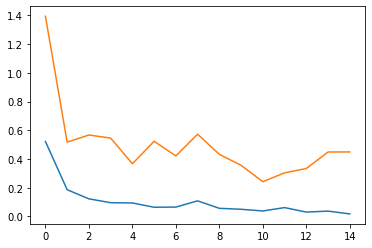

In [18]:
train_loss_per_epoch = model.history.history['loss']
valid_loss_per_epoch = model.history.history['val_loss']
plt.plot(range(len(train_loss_per_epoch)), train_loss_per_epoch, valid_loss_per_epoch)

In [19]:
# split x for test

x_test = test.drop(y_col, axis=1).copy()

test_generator = TimeseriesGenerator(x_test, np.zeros(test[y_col].shape), length = n_input_train, batch_size = b_size_train)
print(test_generator[0][0].shape)


(26, 14, 18)


In [20]:
y_pred_scaled = pd.DataFrame(model.predict(test_generator), columns = y_col)

In [21]:
y_pred_scaled.shape

(26, 2)

In [22]:
# descale

placehold_df = df.copy()
placehold_df[y_col[0]][-y_pred_scaled.shape[0]:] = y_pred_scaled.iloc[:, 0]
placehold_df[y_col[1]][-y_pred_scaled.shape[0]:] = y_pred_scaled.iloc[:, 1]
placehold_df = pd.DataFrame(df_scaler.inverse_transform(placehold_df), columns = placehold_df.columns)
y_pred = placehold_df[y_col][-y_pred_scaled.shape[0]:]

In [23]:
results = pd.DataFrame({'y_true0':df[y_col[0]][train.shape[0] + valid.shape[0] + n_input_train:].values,
                        'y_true1':df[y_col[1]][train.shape[0] + valid.shape[0] + n_input_train:].values,
                        'y_pred0':y_pred.iloc[:, 0], 'y_pred1':y_pred.iloc[:, 1]})
print(results)

      y_true0    y_true1        y_pred0       y_pred1
513  128364.0  4748644.0  121822.197799  4.245968e+06
514  128367.0  4771367.0  122195.371811  4.265973e+06
515  128390.0  4791628.0  122527.217306  4.283635e+06
516  128404.0  4817298.0  122747.743932  4.299687e+06
517  128426.0  4844944.0  122933.568163  4.314387e+06
518  128453.0  4871807.0  123117.620292  4.329335e+06
519  128471.0  4896272.0  123318.807884  4.344308e+06
520  128486.0  4920168.0  123540.413180  4.359814e+06
521  128495.0  4947274.0  123796.227764  4.376833e+06
522  128532.0  4975903.0  124118.349809  4.397259e+06
523  128565.0  5007964.0  124533.422493  4.421148e+06
524  128601.0  5040060.0  125059.136025  4.450381e+06
525  128631.0  5075945.0  125616.038565  4.480905e+06
526  128665.0  5107780.0  126235.781408  4.512552e+06
527  128691.0  5139162.0  126899.256664  4.546480e+06
528  128697.0  5173972.0  127600.639508  4.581599e+06
529  128747.0  5210472.0  128350.994026  4.619788e+06
530  128797.0  5252655.0  12

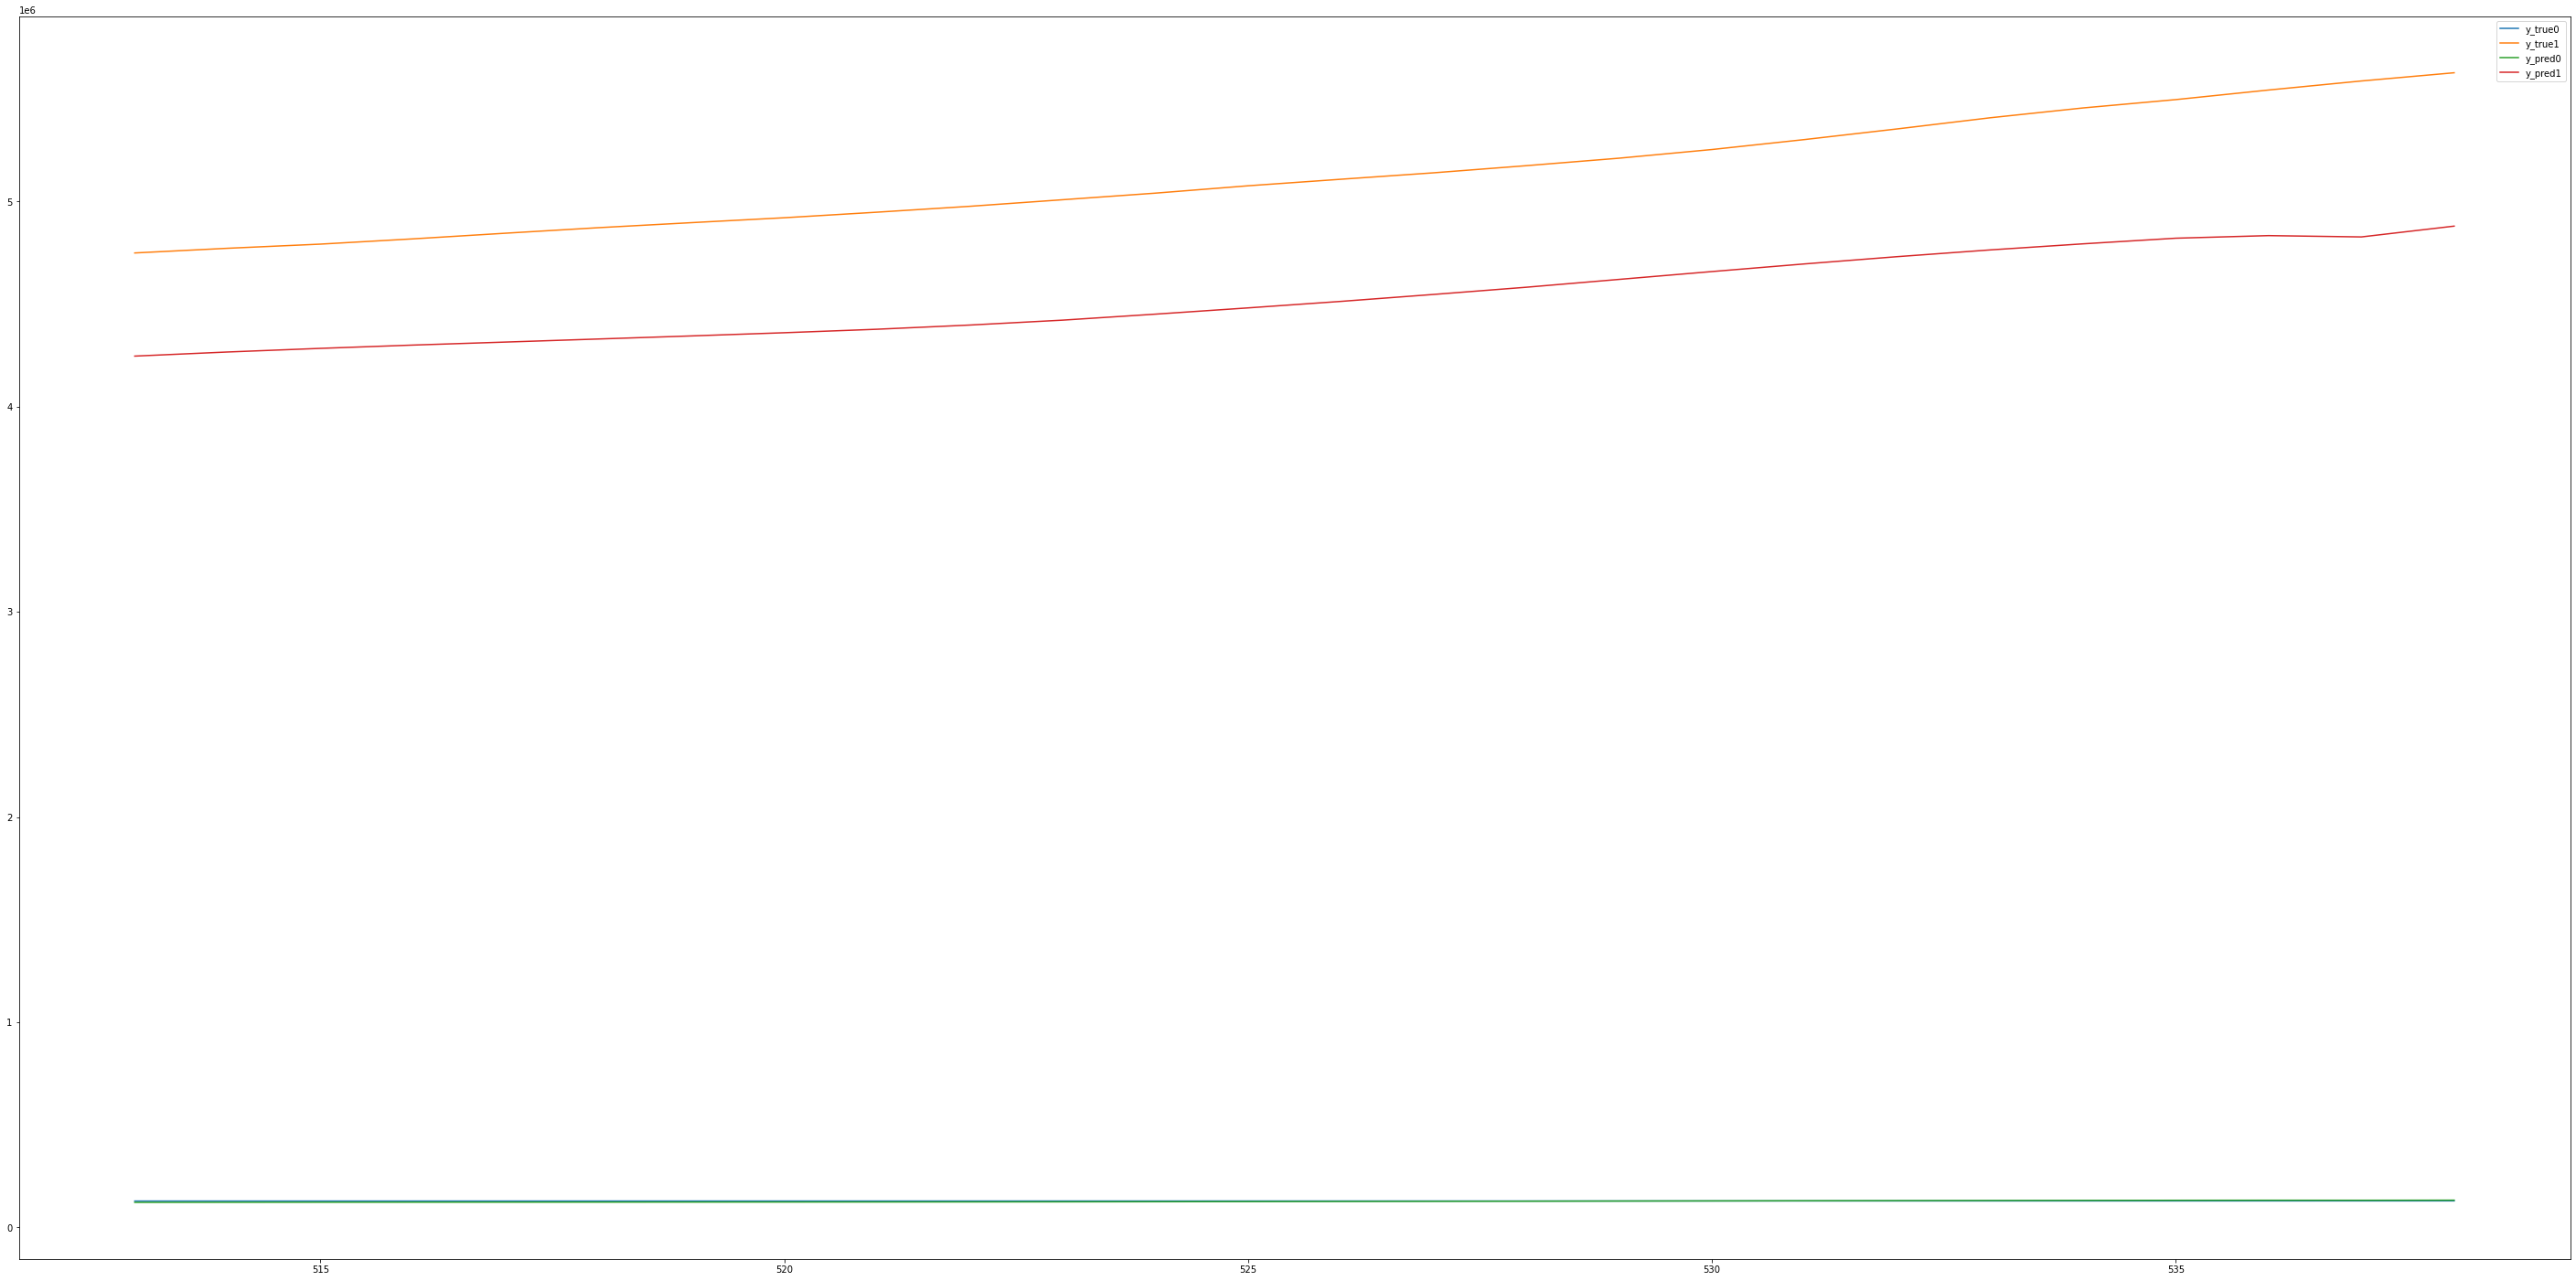

In [24]:
results.plot(figsize=(50,25))

In [25]:
# sMAPE

print(smape(results.iloc[:, 0], results.iloc[:, 2]))
print(smape(results.iloc[:, 1], results.iloc[:, 3]))

2.7536296083246765
12.33275275232862


In [26]:
# MASE

print(mase(train, results.iloc[:, 0], results.iloc[:, 2]))
print(mase(train, results.iloc[:, 1], results.iloc[:, 3]))

1270.1441840984573
217014.88470824683


### prediction intervals

In [27]:
model = Sequential()
model.add(LSTM(150, activation = 'relu', input_shape = (n_input_train, n_features_train)))
model.add(tfp.layers.DenseFlipout(2))
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               101400    
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 2)                 602       
Total params: 102,002
Trainable params: 102,002
Non-trainable params: 0
_________________________________________________________________


/home/mathonsi/anaconda3/envs/rnn01/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


/home/mathonsi/anaconda3/envs/rnn01/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
15/15 [==============================] - 2s 34ms/step - loss: 757.7138 - val_loss: 755.7185
Epoch 2/15
15/15 [==============================] - 0s 17ms/step - loss: 752.6584 - val_loss: 750.7659
Epoch 3/15
15/15 [==============================] - 0s 17ms/step - loss: 748.0292 - val_loss: 746.2038
Epoch 4/15
15/15 [==============================] - 0s 17ms/step - loss: 743.4588 - val_loss: 741.6783
Epoch 5/15
15/15 [==============================] - 0s 17ms/step - loss: 738.9377 - val_loss: 737.1346
Epoch 6/15
15/15 [==============================] - 0s 17ms/step - loss: 734.4775 - val_loss: 732.6707
Epoch 7/15
15/15 [==============================] - 0s 18ms/step - loss: 730.0295 - val_loss: 728.4626
Epoch 8/15
15/15 [==============================] - 0s 16ms/step - loss: 725.5819 - val_loss: 723.7126
Epoch 9/15
15/15 [==============================] - 0s 17ms/step - loss: 721.2316 - val_loss: 719.2844
Epoch 10/15
15/15 [==============================] - 0s 17ms/step - loss:

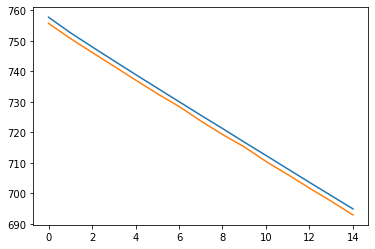

In [28]:
epochs = 15
model.fit_generator(train_generator, validation_data = valid_generator, epochs = epochs)

train_loss_per_epoch = model.history.history['loss']
valid_loss_per_epoch = model.history.history['val_loss']
plt.plot(range(len(train_loss_per_epoch)), train_loss_per_epoch, valid_loss_per_epoch)


In [29]:
runs = 100

df_low = pd.DataFrame()
df_up = pd.DataFrame()

for run in range(runs):
    y_pred_scaled = pd.DataFrame(model.predict(test_generator))
    df_low = df_low.append(y_pred_scaled.iloc[:, 0])
    df_up = df_up.append(y_pred_scaled.iloc[:, 1])

In [30]:
alpha = 0.05 
lower_q = alpha/2
lower_0 = np.quantile(df_low, lower_q, axis = 0)
lower_1 = np.quantile(df_up, lower_q, axis = 0)
upper_q = 1 - alpha + alpha/2
upper_0 = np.quantile(df_low, upper_q, axis = 0)
upper_1 = np.quantile(df_up, upper_q, axis = 0)

In [31]:
lower_0.shape

(26,)

In [32]:
upper_0

array([2.37540365, 2.21703397, 2.49734521, 2.29680852, 2.36912791,
       2.55676571, 2.33258083, 2.31747765, 2.39661609, 2.34300603,
       2.44423474, 2.40763249, 2.50904072, 2.40735677, 2.29100104,
       2.449075  , 2.33103543, 2.32084487, 2.44233353, 2.61032267,
       2.44952002, 2.41413751, 2.43884768, 2.48204415, 2.42862983,
       2.60585407])

In [33]:
# descale lower

placehold_df = df.copy()
placehold_df[y_col[0]][-y_pred_scaled.shape[0]:] = lower_0
placehold_df[y_col[1]][-y_pred_scaled.shape[0]:] = lower_1
placehold_df = pd.DataFrame(df_scaler.inverse_transform(placehold_df), columns = placehold_df.columns)
lower = placehold_df[y_col][-y_pred_scaled.shape[0]:]

# descale upper

placehold_df = df.copy()
placehold_df[y_col[0]][-y_pred_scaled.shape[0]:] = upper_0
placehold_df[y_col[1]][-y_pred_scaled.shape[0]:] = upper_1
placehold_df = pd.DataFrame(df_scaler.inverse_transform(placehold_df), columns = placehold_df.columns)
upper = placehold_df[y_col][-y_pred_scaled.shape[0]:]


In [34]:
# MIS

print(mis(lower.iloc[:, 0].values, upper.iloc[:, 0].values, results.iloc[:, 0].values, alpha = alpha))
print(mis(lower.iloc[:, 1].values, upper.iloc[:, 1].values, results.iloc[:, 1].values, alpha = alpha))

164773.9202558736
6293113.531535417


In [35]:
# coverage

print(coverage(lower.iloc[:, 0].values, upper.iloc[:, 0].values, results.iloc[:, 0].values))
print(coverage(lower.iloc[:, 1].values, upper.iloc[:, 1].values, results.iloc[:, 1].values))

100.0
100.0
